# **Oxford Flowers Clustering Notebook**

In this notebook, we:
1. Load the validation and test splits of the Oxford Flower Dataset, merging them.
2. Compute (or load) the Fisher vectors from the deep extractor.
3. Compute (or load) the VLAD vectors from the deep extractor.
4. Construct a pipeline that combines both encoders.
5. Cluster these images into 102 clusters (the number of classes).
6. Compute ARI, NMI, and interpret the results.

---

## **1. Setup and Load Data**


In [3]:
from torchvision.models import vgg16, VGG16_Weights

from pyvisim.datasets import OxfordFlowerDataset
from pyvisim._utils import *
from pyvisim.features import DeepConvFeature
from pyvisim.encoders import FisherVectorEncoder, VLADEncoder, Pipeline
from pyvisim._config import ROOT

# Load the validation and test datasets.

In [4]:
dataset = OxfordFlowerDataset(purpose=["validation", "test"])
print("Number of images in the dataset:", len(dataset))

Number of images in the dataset: 2040


## **2. Compute VLAD and Fisher vectors**


### **2.1 Load the PCA, GMM and KMeans models**

This requires that you already trained your PCA, GMM and KMeans models on the deep features extracted from the Oxford Flowers dataset and saved them as `pickle` files. If not, you can go to notebook `vlad_with_vgg16_embeddings.ipynb` or `m_ap_and_top_k_accuracy.ipynb` to train and save them.

In [5]:
pca = load_model(rf'{ROOT}/models/pickle_model_files/pca_fisher_k256_deep_features_vgg16_feature_dim257.pkl')
gmm_model = load_model(rf'{ROOT}/models/pickle_model_files/gmm_k256_deep_features_vgg16_pca.pkl')
k_means = load_model(rf'{ROOT}/models/pickle_model_files/k_means_k256_deep_features_vgg16_no_pca.pkl')

### **2.2 Define the feature extractor and the VLAD encoder**

In [6]:
extractor = DeepConvFeature(
    model=vgg16(weights=VGG16_Weights.DEFAULT),
    layer_index=-1)

fisher_vector_encoder = FisherVectorEncoder(
    feature_extractor=extractor,
    gmm_model=gmm_model,
    pca=pca,
    power_norm_weight=0.5,
)

vlad_encoder = VLADEncoder(
    feature_extractor=extractor,
    kmeans_model=k_means,
    power_norm_weight=1.0,
)

pipeline = Pipeline(
    encoders=[fisher_vector_encoder, vlad_encoder]
)

2025-01-10 13:45:04,001 - Feature_Extractor - INFO - Selected layer: features.28, Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### **2.3 Compute the Fisher vectors for both the validation and test splits**

In [8]:
pipeline_encoding_map = pipeline.generate_encoding_map(image_paths=dataset.image_paths)
pipeline_vectors = np.array(list(pipeline_encoding_map.values()))

## **3. Cluster into 102 Clusters and Compute ARI, NMI**

`102` is the number of classes in the Oxford Flowers dataset. We want to see how well the clustering algorithm can cluster the images into these classes.


In [9]:
num_classes = 102
results = cluster_images_and_generate_statistics(
    features=pipeline_vectors,        # The subset corresponding to val+test
    true_labels=np.array(dataset.labels), # The true labels
    n_clusters=num_classes,
    method='spectral'
)

print(f"Clustering with KMeans into {num_classes} clusters:")
print("RI:", results["ri"])
print("ARI:", results["ari"])
print("NMI:", results["nmi"])

C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Clustering with KMeans into 102 clusters:
RI: 0.7967260960293877
ARI: 0.007390570474379638
NMI: 0.12496067905378362


Now, instead of using the vectors themselves, we will use the `similarity matrix` of the vectors to cluster the images. So each row in this matrix will represent the similarity of an image to all other images in the dataset (hence, all diagonal elements will be 1).

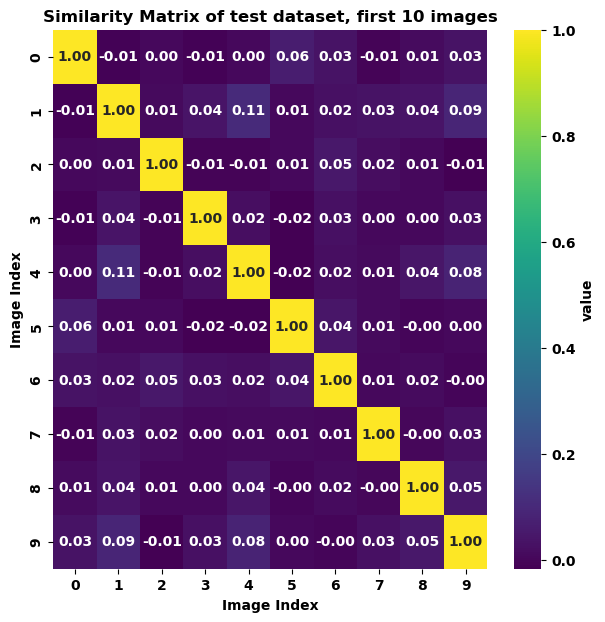

In [10]:
feature_map = cosine_similarity(pipeline_vectors, pipeline_vectors)
plot_and_save_heatmap(feature_map[:10, :10], title="Similarity Matrix of test dataset, first 10 images", x_label="Image Index", y_label="Image Index")

In [11]:
results = cluster_images_and_generate_statistics(
    features=feature_map,        # The subset corresponding to val+test
    true_labels=np.array(dataset.labels), # The true labels
    n_clusters=num_classes,
    method='spectral'
)
print(f"Clustering with Spectral Clustering into {num_classes} clusters:")
print("RI:", results["ri"])
print("ARI:", results["ari"])
print("NMI:", results["nmi"])

C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Clustering with Spectral Clustering into 102 clusters:
RI: 0.9813557203165719
ARI: 0.22851554099240062
NMI: 0.4503660431745761


## **4. Conclusion**

We've demonstrated:
- How to cluster images directly using vectors produced by the pipeline that combines Fisher and VLAD encoders.
- How to compute ARI and NMI for objective evaluation.

Surprisingly, the pipeline performs worse at clustering than either of the encoders alone, even though at `top_k_accuracy` or `top_k_map` (see notebook `m_ap_and_top_k_accuracy`), the pipeline performed better than any of the single encoders.
